In [12]:
# Install kaggle library jika belum terinstall
!pip install kaggle

# Download the dataset using Kaggle API
!kaggle datasets download -d vbookshelf/rice-leaf-diseases

# Unzip the dataset
import zipfile
with zipfile.ZipFile('rice-leaf-diseases.zip', 'r') as zip_ref:
    zip_ref.extractall('rice-leaf-diseases')

Dataset URL: https://www.kaggle.com/datasets/vbookshelf/rice-leaf-diseases
License(s): unknown
rice-leaf-diseases.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

# Define the dataset path
dataset_path = 'rice-leaf-diseases/rice_leaf_diseases'

# Image data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load dataset with ImageDataGenerator
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Check if generators have data
print(f'Number of training samples: {train_generator.samples}')
print(f'Number of validation samples: {validation_generator.samples}')

if train_generator.samples == 0 or validation_generator.samples == 0:
    raise ValueError("The dataset path might be incorrect or the dataset is empty.")

# Calculate steps_per_epoch and validation_steps
steps_per_epoch = max(train_generator.samples // train_generator.batch_size, 1)
validation_steps = max(validation_generator.samples // validation_generator.batch_size, 1)


Found 96 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Number of training samples: 96
Number of validation samples: 24


In [14]:
# Build the model using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base_model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10
)

# Unfreeze the base_model and fine-tune the model
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10
)


Epoch 1/10
3/3 [==============================] - 11s 3s/step - loss: 1.4744 - accuracy: 0.4375 - val_loss: 0.9204 - val_accuracy: 0.7083
Epoch 2/10
3/3 [==============================] - 9s 3s/step - loss: 0.7404 - accuracy: 0.7812 - val_loss: 0.2521 - val_accuracy: 0.8750
Epoch 3/10
3/3 [==============================] - 11s 3s/step - loss: 0.2592 - accuracy: 0.8958 - val_loss: 0.4726 - val_accuracy: 0.7917
Epoch 4/10
3/3 [==============================] - 7s 2s/step - loss: 0.0955 - accuracy: 0.9583 - val_loss: 0.4196 - val_accuracy: 0.8333
Epoch 5/10
3/3 [==============================] - 5s 1s/step - loss: 0.0617 - accuracy: 0.9583 - val_loss: 0.5396 - val_accuracy: 0.7500
Epoch 6/10
3/3 [==============================] - 5s 1s/step - loss: 0.0482 - accuracy: 0.9792 - val_loss: 0.4885 - val_accuracy: 0.7917
Epoch 7/10
3/3 [==============================] - 7s 2s/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.5140 - val_accuracy: 0.9167
Epoch 8/10
3/3 [=======================

1/1 [==============================] - 1s 1s/step - loss: 0.3618 - accuracy: 0.9167
Validation accuracy: 91.67%


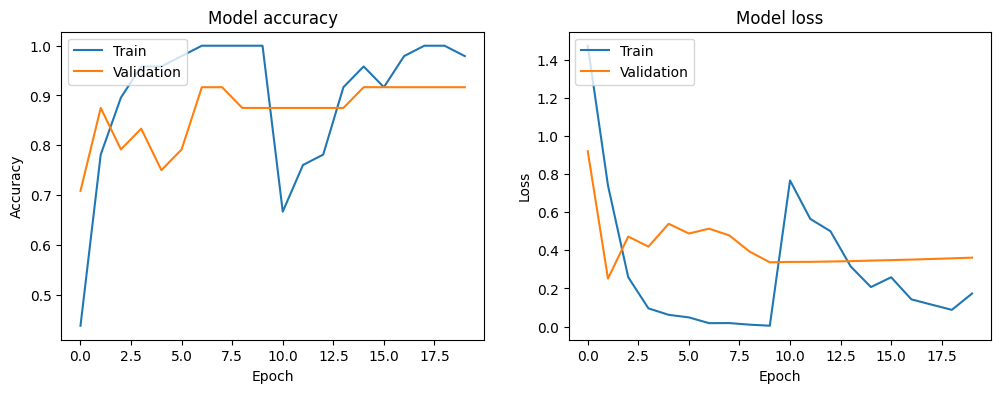

In [15]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


membagi dataset pelatihan dan validasi

In [16]:
# Convert to TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('rice_leaf_diseases_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Test the TFLite model
interpreter = tf.lite.Interpreter(model_path='rice_leaf_diseases_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# Get the output
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)


[[0.4694661  0.07365692 0.45687696]]


proses data

Saving apa-itu-penyakit-bercak-daun.jpg to apa-itu-penyakit-bercak-daun.jpg
Predicted class: brown spot, Confidence: 0.69


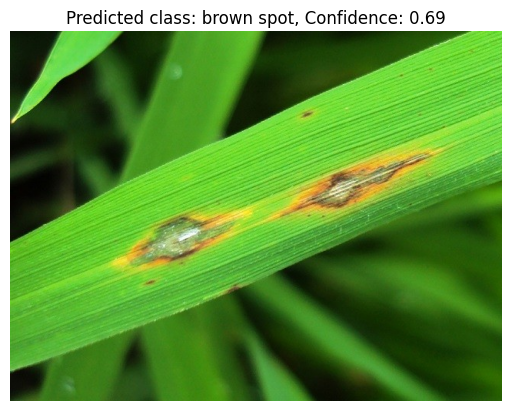

In [24]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import io

# Mapping dari kelas numerik ke nama penyakit
class_names = {
    0: 'bacterial leaf blight',
    1: 'brown spot',
    2: 'leaf smut'
}

# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img).astype(np.float32)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to upload image
def upload_and_classify_image(interpreter):
    # Upload image
    from google.colab import files
    uploaded = files.upload()

    for image_name in uploaded.keys():
        img_array = load_and_preprocess_image(image_name)

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], img_array)

        # Run the model
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Print the prediction
        predicted_class = np.argmax(output_data)
        confidence = np.max(output_data)
        predicted_class_name = class_names[predicted_class]

        print(f'Predicted class: {predicted_class_name}, Confidence: {confidence:.2f}')

        # Show the image
        img = Image.open(image_name)
        plt.imshow(img)
        plt.title(f'Predicted class: {predicted_class_name}, Confidence: {confidence:.2f}')
        plt.axis('off')
        plt.show()

# Call the function to upload and classify image
upload_and_classify_image(interpreter)


Saving DSC_0365.JPG to DSC_0365 (2).JPG
Predicted class: bacterial leaf blight, Confidence: 0.95


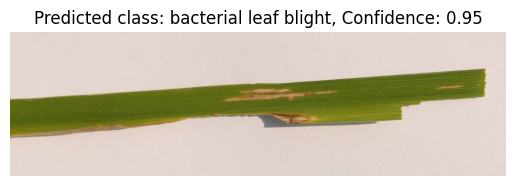

In [21]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import io

# Mapping dari kelas numerik ke nama penyakit
class_names = {
    0: 'bacterial leaf blight',
    1: 'brown spot',
    2: 'leaf smut'
}

# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img).astype(np.float32)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to upload image
def upload_and_classify_image(interpreter):
    # Upload image
    from google.colab import files
    uploaded = files.upload()

    for image_name in uploaded.keys():
        img_array = load_and_preprocess_image(image_name)

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], img_array)

        # Run the model
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Print the prediction
        predicted_class = np.argmax(output_data)
        confidence = np.max(output_data)
        predicted_class_name = class_names[predicted_class]

        print(f'Predicted class: {predicted_class_name}, Confidence: {confidence:.2f}')

        # Show the image
        img = Image.open(image_name)
        plt.imshow(img)
        plt.title(f'Predicted class: {predicted_class_name}, Confidence: {confidence:.2f}')
        plt.axis('off')
        plt.show()

# Call the function to upload and classify image
upload_and_classify_image(interpreter)


Saving DSC_0108.jpg to DSC_0108.jpg
Predicted class: brown spot, Confidence: 0.88


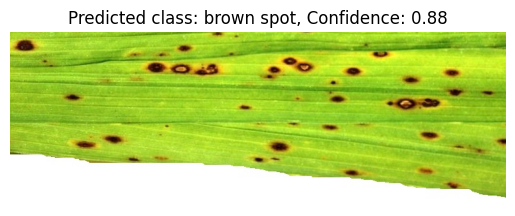

In [22]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import io

# Mapping dari kelas numerik ke nama penyakit
class_names = {
    0: 'bacterial leaf blight',
    1: 'brown spot',
    2: 'leaf smut'
}

# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img).astype(np.float32)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to upload image
def upload_and_classify_image(interpreter):
    # Upload image
    from google.colab import files
    uploaded = files.upload()

    for image_name in uploaded.keys():
        img_array = load_and_preprocess_image(image_name)

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], img_array)

        # Run the model
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Print the prediction
        predicted_class = np.argmax(output_data)
        confidence = np.max(output_data)
        predicted_class_name = class_names[predicted_class]

        print(f'Predicted class: {predicted_class_name}, Confidence: {confidence:.2f}')

        # Show the image
        img = Image.open(image_name)
        plt.imshow(img)
        plt.title(f'Predicted class: {predicted_class_name}, Confidence: {confidence:.2f}')
        plt.axis('off')
        plt.show()

# Call the function to upload and classify image
upload_and_classify_image(interpreter)


Saving images (1).jpeg to images (1).jpeg
Predicted class: brown spot, Confidence: 0.98


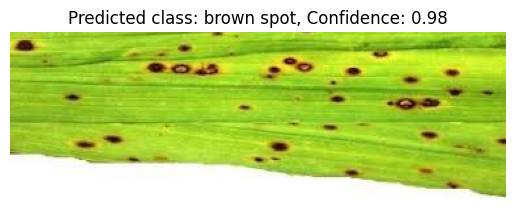

In [25]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import io

# Mapping dari kelas numerik ke nama penyakit
class_names = {
    0: 'bacterial leaf blight',
    1: 'brown spot',
    2: 'leaf smut'
}

# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img).astype(np.float32)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to upload image
def upload_and_classify_image(interpreter):
    # Upload image
    from google.colab import files
    uploaded = files.upload()

    for image_name in uploaded.keys():
        img_array = load_and_preprocess_image(image_name)

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], img_array)

        # Run the model
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Print the prediction
        predicted_class = np.argmax(output_data)
        confidence = np.max(output_data)
        predicted_class_name = class_names[predicted_class]

        print(f'Predicted class: {predicted_class_name}, Confidence: {confidence:.2f}')

        # Show the image
        img = Image.open(image_name)
        plt.imshow(img)
        plt.title(f'Predicted class: {predicted_class_name}, Confidence: {confidence:.2f}')
        plt.axis('off')
        plt.show()

# Call the function to upload and classify image
upload_and_classify_image(interpreter)
